# Exploring Lending Club Loan Default Rates

**Team 7:**
* Lujain Al Qassar
* Yongxian (Caroline) Lun
* Deniz Ipek Ozakyol
* Cordell Williams
* Sihoon (Daniel) Yu

***

**Dataset:** 
    Lending Club Loans from 2013-2020 Q3 (*Source: https://www.kaggle.com/ethon0426/lending-club-20072020q1/version/3*)

**Background:**
    Lending Club (the Club), founded in 2007, is a firm that offers members a broad range of financial instruments to achieve their goals. Personal loans ranging from 500 to 40,000 are the primary product that the Club provides. Many of these loans are facilitated via peer-to-peer transactions, though as the Club has expanded into other markets such as banking, the need for peer-funded transactions has declined. The dataset used for this research project is a sample of 780k peer-to-peer personal loans originated between 2007 and 2020 Q3. The dataset includes loan details such as loan amount, interest rate, and amortization term; as well as borrower financial details such as credit rating score, debt-to-income ratios, and annual income. 
    
**Objective:**
    This research will explore loan distribution and how different loan and borrower characteristics impact the likelihood of default on a personal loan.
    
**Purpose:**
    The underlying goal of most companies is to maximize their return on investment. When it comes to financial services, credit risk management is one of the major factors that impacts the business model. Lending Club is a peer-to-peer financial lending company. The biggest risk to their unsecured loan business is when a borrower fails to repay according to the agreed-upon terms, in other words to default. The default rate is significant because it represents the amount of risk that the company carries by lending their capital, and can differ based on several categories. It could be individual or corporate (we are focusing on individual level for the purpose of this project), county or state, young or old, high income or low income. Based on borrower's individual financial situation, Lending Club can accurately estimate the likelihood of default, and determine the maximum loan amount and interest rate.


----------------------------------------------------------------------------------------------------------------------------------------------

## Summary of the Dataset

The first question in the exploration of any dataset is simple: What does the data look like?

As you can see from the subset of data below, this dataset is packed full of valuable information such as the loan funded amount, interest rate, monthly installment payment, length of employment, annual income, FICO scores, DTI ranges, and so much more! 

*Note: The dataset lists 10 possible outcomes for the loan status. For the purpose of this analysis, we have defined a "Default" as the following possible statuses: ['Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default']; and, we have defined "Current" as the following possible statuses: ['Fully Paid', 'Current', 'Does not meet the credit policy. Status:Fully Paid', 'In Grace Period', 'Late (16-30 days)','Issued'].*

In [3]:
%%bigquery

SELECT 
    id AS ID,
    funded_amnt AS Funded_Amount,
    term AS Amortization_Term,
    int_rate AS Interest_Rate, 
    installment AS Installment, 
    emp_length AS Employee_Length, 
    home_ownership AS Home_Ownership, 
    annual_inc AS Annual_Income, 
    loan_status AS Loan_Status, 
    purpose AS Purpose, 
    addr_state AS Address_State,
    delinq_2yrs AS Delinq_2years,
    fico_range_low AS FICO_Range,
    application_type AS Application_Type,
    dti
FROM
    `ba775-b2-team7-groupproject.Lending_Club_datasets.lending_club_loan_data`
LIMIT 5

Downloading: 100%|██████████| 5/5 [00:01<00:00,  4.32rows/s]


,ID,Funded_Amount,Amortization_Term,Interest_Rate,Installment,Employee_Length,Home_Ownership,Annual_Income,Loan_Status,Purpose,Address_State,Delinq_2years,FICO_Range,Application_Type,dti
0,3874568,10000.0,36 months,0.1433,343.39,10+ years,MORTGAGE,71000.0,Fully Paid,credit_card,NY,0.0,690.0,Individual,23.07
1,4095098,10000.0,36 months,0.1580,350.59,10+ years,RENT,71000.0,Charged Off,debt_consolidation,NJ,0.0,665.0,Individual,22.28
2,4465773,10000.0,36 months,0.1580,350.59,10+ years,RENT,51000.0,Fully Paid,debt_consolidation,NY,0.0,675.0,Individual,16.17
3,4254984,6000.0,36 months,0.0603,182.62,2 years,MORTGAGE,90000.0,Fully Paid,credit_card,FL,0.0,755.0,Individual,6.38
4,4445709,30225.0,36 months,0.1849,1100.16,10+ years,MORTGAGE,134000.0,Fully Paid,debt_consolidation,DC,2.0,670.0,Individual,12.99


----------------------------------------------------------------------------------------------------------------------------------------------

For the purposes of our exploration into the factors that influence credit default risk, we have chosen to narrow the features of our dataset to the following variables:
* term: amortization period of the loan (can be 36 or 60)
* purpose: borrower self-reported purpose of the loan
* funded_amnt: the actual loan amount funded
* fico_range_low: minimum range of FICO (note: fico_range_high is fico_range_low +4)
* int_rate: interest rate on the loan
* home_ownership: home ownership status
* emp_length: length of primary borrower employment
* dti: Debt-to-Income
* annual_inc: primary borrower self-reported annual income
* addr_state: state in which loan was funded
* application_type: individual vs. joint application type

**So, what would a summary of our data set look like through the lenses of our features?**

In [6]:
  %%bigquery
SELECT
  "LC Loan '13-'20Q3" AS Dataset,
  COUNT(*)/1000 AS Loan_Count_Thsnd,
  ROUND(SUM(funded_amnt)/1000000,2) AS Funded_Vol_Mil,
  ROUND(AVG(funded_amnt),2) AS Avg_Funded_Vol,
  ROUND(SUM(int_rate_numerator)/SUM(funded_amnt),4) AS waInterestRate,
  ROUND(SUM(fico_numerator)/SUM(funded_amnt),2) AS waFICO,
  ROUND(SUM(dti_numerator)/SUM(funded_amnt),2) AS waDTI,
  ROUND(SUM(borrower_count_numerator)/SUM(funded_amnt),2) AS waBorrowerCount,
  ROUND(SUM(emp_len_numerator)/SUM(funded_amnt),2) AS waEmployeeLength_years,
  CAST(SUM(income_numerator)/SUM(funded_amnt) AS INT64) AS waIncome,
  ROUND(SUM(amortization_numerator)/SUM(funded_amnt),2) AS waAmortization_months,
  ROUND(AVG(CASE
        WHEN home_ownership IN ('MORTGAGE', 'OWN') THEN 1
      ELSE
      0
    END
      ),4) AS PctHomeOwner,
  ROUND(SUM(default_volume)/SUM(funded_amnt),4) AS Default_Rate
FROM (
  SELECT
    *,
    CASE
      WHEN loan_status IN ('Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default') THEN 'Default'
    ELSE
    'Current'
  END
    AS Loan_Status,
    CASE
      WHEN loan_status IN ('Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default') THEN funded_amnt
    ELSE
    0
  END
    AS Default_Volume,
    int_rate*funded_amnt AS Int_Rate_Numerator,
    fico_range_low*funded_amnt AS FICO_Numerator,
    dti*funded_amnt AS DTI_Numerator,
    annual_inc*funded_amnt AS Income_Numerator,
    (CASE
        WHEN application_type = 'Individual' THEN 1
      ELSE
      2
    END
      ) * funded_amnt AS Borrower_Count_Numerator,
    (CASE
        WHEN emp_length LIKE '< 1%' THEN 0
        WHEN emp_length LIKE '10+%' THEN 10
      ELSE
      CAST(LEFT(emp_length,1) AS INT64)
    END
      ) * funded_amnt AS Emp_Len_Numerator,
    CAST(LEFT(TRIM(term),2) AS INT64)*funded_amnt AS Amortization_Numerator,
  FROM
    `ba775-b2-team7-groupproject.Lending_Club_datasets.lending_club_loan_data`)

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.05s/rows]


,Dataset,Loan_Count_Thsnd,Funded_Vol_Mil,Avg_Funded_Vol,waInterestRate,waFICO,waDTI,waBorrowerCount,waEmployeeLength_years,waIncome,waAmortization_months,PctHomeOwner,Default_Rate
0,LC Loan '13-'20Q3,785.466,10755.13,13692.68,0.1422,697.09,18.86,1.04,5.76,87631,42.56,0.5754,0.1771


In [13]:
%%bigquery
SELECT
  addr_state AS State,
  ROUND(SUM(funded_amnt)/1000000,2) AS Total_Loan_Volume_in_Mil
FROM
  `ba775-b2-team7-groupproject.Lending_Club_datasets.lending_club_loan_data`
GROUP BY
  addr_state
ORDER BY
  Total_Loan_Volume_in_Mil DESC
LIMIT
  10;

Downloading: 100%|██████████| 10/10 [00:01<00:00,  9.71rows/s]


,State,Total_Loan_Volume_in_Mil
0,CA,1604.22
1,TX,919.72
2,NY,901.71
3,FL,735.01
4,IL,440.93
5,NJ,418.79
6,GA,354.33
7,PA,350.22
8,OH,333.36
9,VA,323.08


As can be seen from the results set of the prior two queries, we've got some interesting baseline facts about what our dataset looks like:
* 785,466 total loans represented
* 10.7B in funded volume
* 14.22% weighted average (wa) interest rate
* The wa FICO score is 697 and the wa debt-to-income (DTI) ratio is 18.9%.
* The wa primary borrower income is 87.6K annually, and 57% of borrowers own their own homes.
* The average default rate for the entire population of loans is 17.7%.
* The top three states by funded volume are CA, TX, and NY which represent roughly 32% of all lending activity.

----------------------------------------------------------------------------------------------------------------------------------------------

# Dataset Features and Default Rates

As mentioned above, we have chosen to narrow the dimensions of our features to core factors that are generally known to impact the performance of a loan. After analyzing each of these features separately, we've determined that FICO and income group seemed to be the largest determinants of potential default, but all of the features play a role in ultimately predicting the likelihood of default on a personal loan. 

### How does default rate differ by loan purpose?

The Lending Club offers borrowers 14 options when selecting the purpose of the personal loan. These loan purpose descriptions vary from traditional debt consolidations to wedding and medical expenses. Debt consolidation and credit card payoffs were by-far the largest groups in terms of funded loan volume. However, small business had the highest rate of default at nearly 28! This is likely due to small business owners turning to a personal loan as a last resort in an effort to salvage a failing business. Notably, small business loans also tend to have higher weighted average interest rates than the rest of the population. 

In [10]:
%%bigquery
WITH
  purpose_data AS (
  SELECT
    CASE
      WHEN purpose IN ('home_improvement', 'renewable_energy', 'house') THEN 'home_improvement'
    ELSE
    purpose
  END
    AS Loan_Purpose,
    funded_amnt,
    int_rate*funded_amnt AS int_rate_numerator,
    fico_range_low*funded_amnt AS fico_numerator,
    dti*funded_amnt AS dti_numerator,
    annual_inc*funded_amnt AS inc_numerator,
    (CASE
        WHEN application_type = 'Individual' THEN 1
      ELSE
      2
    END
      ) * funded_amnt AS borr_ct_numerator,
    (CASE
        WHEN emp_length LIKE '< 1%' THEN 0
        WHEN emp_length LIKE '10+%' THEN 10
      ELSE
      CAST(LEFT(emp_length,1) AS INT64)
    END
      ) * funded_amnt AS emp_len_numerator,
    CAST(LEFT(TRIM(term),2) AS INT64)*funded_amnt AS term_numerator,
    CASE
      WHEN loan_status IN ('Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default') THEN 'Default'
    ELSE
    'Current'
  END
    AS loan_status,
    CASE
      WHEN loan_status IN ('Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default') THEN funded_amnt
    ELSE
    0
  END
    AS Default_Vol,
    home_ownership,
  FROM
    `ba775-b2-team7-groupproject.Lending_Club_datasets.lending_club_loan_data` )
SELECT
  Loan_Purpose,
  ROUND(COUNT(*)/1000,2) AS Loan_Count_Thsnd,
  ROUND(SUM(funded_amnt)/1000000,2) AS Total_Funded_Vol_in_Mil,
  CAST(AVG(funded_amnt) AS INT64) AS Avg_Loan_Amount,
  ROUND(SUM(int_rate_numerator)/SUM(funded_amnt),4) AS waInterestRate,
  ROUND(AVG(CASE
        WHEN loan_status = 'Default' THEN 1
      ELSE
      0
    END
      ),4) AS LoanCount_DefaultRate,
  ROUND(SUM(default_vol)/SUM(funded_amnt),4) AS FundedVol_DefaultRate
FROM
  purpose_data
GROUP BY
  Loan_Purpose
ORDER BY
  FundedVol_DefaultRate DESC

Downloading: 100%|██████████| 12/12 [00:01<00:00, 10.62rows/s]


,Loan_Purpose,Loan_Count_Thsnd,Total_Funded_Vol_in_Mil,Avg_Loan_Amount,waInterestRate,LoanCount_DefaultRate,FundedVol_DefaultRate
0,small_business,11.19,168.24,15038,0.1649,0.2577,0.2798
1,educational,0.41,2.66,6508,0.1214,0.1980,0.2141
2,moving,6.58,47.48,7217,0.1593,0.1864,0.2049
3,other,53.81,488.58,9080,0.1571,0.1708,0.1974
4,vacation,6.38,36.75,5758,0.1460,0.1502,0.1945
5,medical,10.26,82.26,8021,0.1497,0.1662,0.1883
6,debt_consolidation,445.93,6562.44,14716,0.1460,0.1766,0.1858
7,major_purchase,18.30,194.85,10651,0.1408,0.1450,0.1799
8,home_improvement,55.59,738.21,13279,0.1417,0.1488,0.1674
9,credit_card,165.54,2335.53,14109,0.1270,0.1370,0.1441


### How does default rate differ by loan amount range?

Discoveries:
1. Within the loan_amount range of 8000 - 15000 dollar, it has the highest total loan amount which means that 8000-15000 is the most popular range of loans. 
2. We clearly see that the higher the amount borrowed, the higher the interest rate is. 
3. Also, borrowers with higher FICO score and greater capacity to pay back the money (higher debt-to-income rate) is likely to get a larger loan amount. 
4. The application of the loan is mostly individual instead of joint. 
5. Borrowers with own home or mortgage is more likely to borrow larger loan amount versus people who rent the house. 
6. The larger amount lended out, the higher default rate is going to be. The lender will take higher risk of not getting fully paid back and losing more. 

In [11]:
%%bigquery
WITH
  weighted_value AS (
  SELECT
    fico_range_low,
    funded_amnt,
    id,
    (int_rate * funded_amnt) AS intRate_weighted_value,
    (fico_range_low*funded_amnt) AS fico_weighted_value,
    (dti*funded_amnt) AS dti_weighted_value,
    CAST(ARRAY_TO_STRING(SPLIT(REGEXP_REPLACE(emp_length, r'[^\d]+', ',')),"") AS INT64 )*funded_amnt AS emp_length_weighted_value,
    CAST(ARRAY_TO_STRING(SPLIT(REGEXP_REPLACE(term, r'[^\d]+', ',')),"") AS INT64 )*funded_amnt AS term_weighted_value,
    (CASE
        WHEN application_type = 'Individual' THEN 1
      ELSE
      2
    END
      )*funded_amnt AS borrCt_weighted_value,
    (CASE
        WHEN home_ownership IN ('MORTGAGE', 'OWN') THEN 1
      ELSE
      0
    END
      )* funded_amnt AS home_owner_weighted_value,
    (CASE
        WHEN loan_status IN ('Default', 'Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off') THEN funded_amnt
      ELSE
      0
    END
      ) AS default_amnt
  FROM
    `ba775-b2-team7-groupproject.Lending_Club_datasets.lending_club_loan_data` )
SELECT
  CASE
    WHEN funded_amnt BETWEEN 500 AND 8000 THEN 'E. 500-8000'
    WHEN funded_amnt BETWEEN 8001 AND 15500 THEN 'D. 8000-15500'
    WHEN funded_amnt BETWEEN 15501 AND 23000 THEN 'C. 15500-23000'
    WHEN funded_amnt BETWEEN 23001 AND 30500 THEN 'B. 23000-30500'
    WHEN funded_amnt BETWEEN 30501 AND 40000 THEN 'A. 30500-40000'
  ELSE
  'others'
END
  AS Loan_Amount_Range,
  COUNT(id)/1000 Num_of_Loans_Thsnd,
  ROUND(SUM(funded_amnt)/100000,2) Total_Loan_Amount_Mil,
  ROUND(AVG(funded_amnt),2) Avg_Loan_Amount,
  --- count how many transactions/number OF loans funded OUT 
  ROUND(SUM(intRate_weighted_value)/SUM(funded_amnt),4) AS waIntRate,
  ROUND(SUM(CASE when default_amnt = 0 THEN 0 ELSE 1 END)/COUNT(*),4) AS LoanCount_DefaultRate,
  ROUND(SUM(default_amnt)/SUM(funded_amnt),4) AS FundedVol_DefaultRate
FROM
  weighted_value AS w
GROUP BY
  loan_amount_range
ORDER BY
  loan_amount_range

Downloading: 100%|██████████| 5/5 [00:00<00:00,  5.02rows/s]


,Loan_Amount_Range,Num_of_Loans_Thsnd,Total_Loan_Amount_Mil,Avg_Loan_Amount,waIntRate,LoanCount_DefaultRate,FundedVol_DefaultRate
0,A. 30500-40000,44.610,15606.74,34984.84,0.1539,0.1922,0.1903
1,B. 23000-30500,81.045,21489.14,26515.07,0.1484,0.1891,0.1895
2,C. 15500-23000,139.287,26317.28,18894.28,0.1423,0.1871,0.1870
3,D. 8000-15500,265.976,31028.42,11665.87,0.1360,0.1670,0.1678
4,E. 500-8000,254.548,13109.73,5150.20,0.1331,0.1393,0.1433


### How does default rate differ by income group?

Income range is also a very intuitive and useful criteria to analyze the default rate and general characteristics of a borrower.
There are four groups- no income, low income (annual income <=47,900), mid income (47900 < income <= 74400), and high income (income > 74400).
We used median to lessen the outlier effect and median * 0.8 = low and median * 1.2 = high income. The results show that while the default rate for the high-income population is 12.7%, that rate jumps to 20.7% for the low-income. Interestingly, the group that reports no income has the lowest default rates; although, that could be slightly biased by the low loan volume.
Average Fico score, employment length, average term, borrower count, percentage of homeowner, loan amount and total counts showed linear relationship with the income, whereas interest rate, debt to income had inverse relationship.
From the loan purpose table we saw, people with high income borrowed money for small business and home improvement which had an average of 42 months terms, whereas people with lower income spent their capital on education and car which are more focused towards satisfying basic needs. 

In [2]:
%%bigquery
SELECT
  CASE
    WHEN annual_inc = 0 THEN 'D. No Income'
    WHEN annual_inc <= 47900 THEN 'A. Low Income'
    WHEN annual_inc <= 74400 THEN 'B. Moderate Income'
    WHEN annual_inc > 74400 THEN 'C. High Income'
END
  AS Income_Group,
  COUNT(id)/1000 AS Total_Counts_thsnd,
  ROUND(SUM(funded_amnt)/1000000,2) AS Total_Loan_Amount_mlns,
  ROUND(AVG(funded_amnt),2) AS Avg_Loan_Amount,
  ROUND(SUM(int_rate_numerator)/SUM(funded_amnt),4) AS Avg_IntRate,
  ROUND(SUM(CASE
        WHEN loan_status IN ('Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default') THEN 1
      ELSE
      0
    END
      )/COUNT(*),4) AS LoanCount_DefaultRate,
  ROUND(SUM(CASE
        WHEN loan_status IN ('Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default') THEN funded_amnt
      ELSE
      0
    END
      )/SUM(funded_amnt),4) AS FundedVolume_DefaultRate
FROM (
  SELECT
    *,
    int_rate*funded_amnt AS int_rate_numerator
  FROM
    `ba775-b2-team7-groupproject.Lending_Club_datasets.lending_club_loan_data`)
WHERE annual_inc IS NOT NULL
GROUP BY
  income_group
ORDER BY
  income_group

Downloading: 100%|██████████| 4/4 [00:01<00:00,  3.77rows/s]


,Income_Group,Total_Counts_thsnd,Total_Loan_Amount_mlns,Avg_Loan_Amount,Avg_IntRate,LoanCount_DefaultRate,FundedVolume_DefaultRate
0,A. Low Income,231.754,2031.41,8765.39,0.1477,0.1912,0.2069
1,B. Moderate Income,260.505,3366.35,12922.41,0.1451,0.1719,0.1944
2,C. High Income,292.864,5352.12,18275.10,0.1383,0.1390,0.1550
3,D. No Income,0.339,5.22,15400.22,0.1560,0.1239,0.1265


### How does default rate differ by FICO rating?

Using the Experian credit rating groups (https://www.experian.com/blogs/ask-experian/infographic-what-are-the-different-scoring-ranges/), we separated the loan population into various FICO groups to understand how loans perform based upon credit score. Unsurprisingly, there is a very strong correlation between FICO score and probability of default. For Very Good and Exceptional credit scores, the default rate is below 10%; however, that number jumps to 18% for Good credit scores and 24% for Fair credit scores. This seems to be a large determinant in the likelihood of default.

In [13]:
%%bigquery
SELECT
  CASE
    WHEN fico_range_low < 580 THEN 'Poor'
    WHEN fico_range_low <= 669 THEN 'Fair'
    WHEN fico_range_low <= 739 THEN 'Good'
    WHEN fico_range_low <= 799 THEN 'Very Good'
  ELSE
  'Exceptional'
END
  AS FICO_Rating,
  COUNT(*) AS Loan_Count,
  ROUND(SUM(funded_amnt)/1000000,4) AS Funded_Volume,
  ROUND(AVG(funded_amnt),0) AS Average_Loan_Amount,
  ROUND(SUM(int_rate_numerator)/SUM(funded_amnt),4) AS waInterestRate,
  ROUND(SUM(CASE
        WHEN loan_status='Fully Paid' OR loan_status='Current' OR loan_status='Does not meet the credit policy. Status:Fully Paid' OR loan_status='In Grace Period' OR loan_status='Late (16-30 days)' OR loan_status='Issued' THEN 0
      ELSE
      1
    END
      )/COUNT(funded_amnt),4) AS LoanCount_DefaultRate,
  ROUND(SUM(CASE
        WHEN loan_status='Fully Paid' OR loan_status='Current' OR loan_status='Does not meet the credit policy. Status:Fully Paid' OR loan_status='In Grace Period' OR loan_status='Late (16-30 days)' OR loan_status='Issued' THEN 0
      ELSE
      funded_amnt
    END
      )/SUM(funded_amnt),4) AS FundedVolume_DefaultRate,
FROM (
  SELECT
    *,
    int_rate*funded_amnt AS int_rate_numerator
  FROM
    `ba775-b2-team7-groupproject.Lending_Club_datasets.lending_club_loan_data`)
GROUP BY
  FICO_Rating
ORDER BY
  FundedVolume_DefaultRate DESC;

Downloading: 100%|██████████| 4/4 [00:01<00:00,  3.99rows/s]


,FICO_Rating,Loan_Count,Funded_Volume,Average_Loan_Amount,waInterestRate,LoanCount_DefaultRate,FundedVolume_DefaultRate
0,Fair,141996,1717.5832,12096.0,0.1658,0.2200,0.2428
1,Good,562554,7873.4033,13996.0,0.1436,0.1643,0.1762
2,Very Good,73165,1054.5831,14414.0,0.0994,0.0795,0.0895
3,Exceptional,7751,109.5613,14135.0,0.0858,0.0477,0.0560


### How does default rate differ by debt-to-income (DTI) ratios?

As the DTI increases on a loan, the rate of default also increases. Loans with DTI <15% have a default rate of 14.8% compared to borrower with DTI's between 30% and 35% who default at a rate of 23%. Surprisingly, the default rate decreases for loans where the DTI is >35%. 

In [12]:
%%bigquery
SELECT
  CASE
    WHEN dti < 15 THEN 'A. <15%'
    WHEN dti <= 20 THEN 'B. 15%-20%'
    WHEN dti <= 25 THEN 'C. 20%-25%'
    WHEN dti <= 30 THEN 'D. 25%-30%'
    WHEN dti <= 35 then 'E. 30%-35%'
    ELSE 'F. >35%'
END
  AS DTI_Grouping,
  COUNT(*) AS Loan_Count,
  ROUND(SUM(funded_amnt)/1000000,2) AS Funded_Volume,
  ROUND(AVG(funded_amnt),0) AS Average_Loan_Amount,
  ROUND(SUM(int_rate_numerator)/SUM(funded_amnt),4) AS waInterestRate,
  ROUND(SUM(CASE
        WHEN loan_status='Fully Paid' OR loan_status='Current' OR loan_status='Does not meet the credit policy. Status:Fully Paid' OR loan_status='In Grace Period' OR loan_status='Late (16-30 days)' OR loan_status='Issued' THEN 0
      ELSE
      1
    END
      )/COUNT(funded_amnt),4) AS LoanCount_DefaultRate,
  ROUND(SUM(CASE
        WHEN loan_status='Fully Paid' OR loan_status='Current' OR loan_status='Does not meet the credit policy. Status:Fully Paid' OR loan_status='In Grace Period' OR loan_status='Late (16-30 days)' OR loan_status='Issued' THEN 0
      ELSE
      funded_amnt
    END
      )/SUM(funded_amnt),4) AS FundedVolume_DefaultRate,
FROM (
  SELECT
    *,
    int_rate*funded_amnt AS int_rate_numerator
  FROM
    `ba775-b2-team7-groupproject.Lending_Club_datasets.lending_club_loan_data`)
GROUP BY
  DTI_Grouping
ORDER BY
  DTI_Grouping ASC;

Downloading: 100%|██████████| 6/6 [00:00<00:00,  6.06rows/s]


,DTI_Grouping,Loan_Count,Funded_Volume,Average_Loan_Amount,waInterestRate,LoanCount_DefaultRate,FundedVolume_DefaultRate
0,A. <15%,298987,3940.56,13180.0,0.1332,0.1369,0.1481
1,B. 15%-20%,165813,2328.90,14045.0,0.1400,0.1608,0.1720
2,C. 20%-25%,141221,1981.93,14034.0,0.1457,0.1794,0.1911
3,D. 25%-30%,97323,1372.53,14103.0,0.1506,0.1992,0.2108
4,E. 30%-35%,56953,777.37,13649.0,0.1617,0.2169,0.2302
5,F. >35%,25169,353.84,14058.0,0.1628,0.2052,0.2080


### How does default rate differ by number of borrowers?

The Lending Club uses the application type to identify whether a loan was applied for indidivually or with a co-signer. Looking at the default rate by borrower count, we see that loans with two borrowers tend to perform better than loans with one borrower. This is likely due to the fact that two people are responsible, so if the primary borrower is unable to pay, the co-signer is liable to step-in and avoid payment default. Interestingly, the individual borrowers have a lower weighted average interest rate than co-borrower loans.

In [14]:
%%bigquery
SELECT
  application_type AS Application_Type,
  COUNT(*) AS Loan_Count,
  ROUND(SUM(funded_amnt)/1000000,4) AS Funded_Volume_Mil,
  ROUND(AVG(funded_amnt),0) AS Average_Loan_Amount,
  ROUND(SUM(int_rate_numerator)/SUM(funded_amnt),4) AS waInterestRate,
  ROUND(SUM(CASE
      WHEN loan_status IN ('Default', 'Charged Off', 'Does not meet the credit policy. Status:Charged off', 'Late (31-120 days)') THEN 1
    ELSE
    0
  END
    )/COUNT(*),4) AS Pct_of_Num_of_Loans_Defaulted,
  ROUND(SUM(default_amnt)/SUM(funded_amnt),4) AS Pct_of_Loan_Dollars_Defaulted
FROM (
  SELECT
    *, int_rate*funded_amnt as int_rate_numerator,
    CASE
      WHEN loan_status='Fully Paid' OR loan_status='Current' OR loan_status='Does not meet the credit policy. Status:Fully Paid' OR loan_status='In Grace Period' OR loan_status='Late (16-30 days)' OR loan_status='Issued' THEN 0
    ELSE
    funded_amnt
  END
    AS default_amnt
  FROM
    `ba775-b2-team7-groupproject.Lending_Club_datasets.lending_club_loan_data`)
GROUP BY
  application_type
ORDER BY
  Pct_of_Loan_Dollars_Defaulted DESC;

Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.86rows/s]


,Application_Type,Loan_Count,Funded_Volume_Mil,Average_Loan_Amount,waInterestRate,Pct_of_Num_of_Loans_Defaulted,Pct_of_Loan_Dollars_Defaulted
0,Individual,760768,10345.6784,13599.0,0.1421,0.1656,0.179
1,Joint App,24698,409.4525,16578.0,0.1470,0.1252,0.130


### How does default rate differ by amortization period?

The loans that have a 60 month repayment period default at nearly twice the rate of loans with a 36 amortization term. This is likely impacted by the higher average loan amounts for the 60 month loans. This is a large determinant of performance (and is reflected in the differences in weighted average interest rates).

In [15]:
%%bigquery
SELECT
  term AS Amortization,
  COUNT(*) AS Loan_Count,
  ROUND(SUM(funded_amnt)/1000000,2) AS Funded_Volume_Mil,
  ROUND(AVG(funded_amnt),0) AS Average_Loan_Amount,
  ROUND(SUM(int_rate_numerator)/SUM(funded_amnt),4) AS waInterestRate,
  ROUND(SUM(CASE
      WHEN loan_status IN ('Default', 'Charged Off', 'Does not meet the credit policy. Status:Charged off', 'Late (31-120 days)') THEN 1
    ELSE
    0
  END
    )/COUNT(*),4) AS Pct_of_Num_of_Loans_Defaulted,
  ROUND(SUM(default_amnt)/SUM(funded_amnt),4) AS Pct_of_Loan_Dollars_Defaulted
FROM (
  SELECT
    *, int_rate*funded_amnt as int_rate_numerator,
    CASE
      WHEN loan_status='Fully Paid' OR loan_status='Current' OR loan_status='Does not meet the credit policy. Status:Fully Paid' OR loan_status='In Grace Period' OR loan_status='Late (16-30 days)' OR loan_status='Issued' THEN 0
    ELSE
    funded_amnt
  END
    AS default_amnt
  FROM
    `ba775-b2-team7-groupproject.Lending_Club_datasets.lending_club_loan_data`)
GROUP BY
  Amortization
ORDER BY
  Pct_of_Loan_Dollars_Defaulted DESC;

Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.93rows/s]


,Amortization,Loan_Count,Funded_Volume_Mil,Average_Loan_Amount,waInterestRate,Pct_of_Num_of_Loans_Defaulted,Pct_of_Loan_Dollars_Defaulted
0,60 months,147294,2941.73,19972.0,0.1740,0.2560,0.2566
1,36 months,638172,7813.40,12243.0,0.1303,0.1432,0.1472


### How does default rate differ by length of employment?

Interestingly, there is very little differentiation in the default rates based upon the number of years employed. This does not seem to be an impactful feature.

In [16]:
%%bigquery
SELECT
  CASE WHEN emp_length LIKE '< 1%' THEN 'A. <1 year'
        WHEN emp_length LIKE '10+%' THEN 'D. 10+ years'
        WHEN CAST(LEFT(emp_length,1) AS INT64) <= 5 THEN 'B. 1-5 years'
        ELSE 'C. 6-10 years'
  END AS Employment_Length,
  COUNT(*) AS Loan_Count,
  ROUND(SUM(funded_amnt)/1000000,2) AS Funded_volume_Mil,
  ROUND(AVG(funded_amnt),0) AS Average_Loan_Amount,
  ROUND(SUM(int_rate_numerator)/SUM(funded_amnt),4) AS waInterestRate,
  ROUND(SUM(CASE
      WHEN loan_status IN ('Default', 'Charged Off', 'Does not meet the credit policy. Status:Charged off', 'Late (31-120 days)') THEN 1
    ELSE
    0
  END
    )/COUNT(*),4) AS Pct_of_Num_of_Loans_Defaulted,
  ROUND(SUM(default_amnt)/SUM(funded_amnt),4) AS Pct_of_Loan_Dollars_Defaulted
FROM (
  SELECT
    *, int_rate*funded_amnt as int_rate_numerator,
    CASE
      WHEN loan_status='Fully Paid' OR loan_status='Current' OR loan_status='Does not meet the credit policy. Status:Fully Paid' OR loan_status='In Grace Period' OR loan_status='Late (16-30 days)' OR loan_status='Issued' THEN 0
    ELSE
    funded_amnt
  END
    AS default_amnt
  FROM
    `ba775-b2-team7-groupproject.Lending_Club_datasets.lending_club_loan_data`)
GROUP BY
  Employment_Length
ORDER BY
  Employment_Length;

Downloading: 100%|██████████| 4/4 [00:01<00:00,  3.94rows/s]


,Employment_Length,Loan_Count,Funded_volume_Mil,Average_Loan_Amount,waInterestRate,Pct_of_Num_of_Loans_Defaulted,Pct_of_Loan_Dollars_Defaulted
0,A. <1 year,66898,872.21,13038.0,0.1407,0.1617,0.1732
1,B. 1-5 years,287508,3764.62,13094.0,0.1420,0.1626,0.1770
2,C. 6-10 years,184242,2411.44,13088.0,0.1428,0.1794,0.1894
3,D. 10+ years,246818,3706.86,15019.0,0.1425,0.1559,0.1701


### How does default rate differ by home ownership status?

Home ownership can be a large predictor in whether a borrower is financially stable enough to support the repayment of a loan. The default rate of homeowners (16%) is materially lower than that of renters (20.5%). 

In [17]:
%%bigquery
SELECT
  CASE WHEN home_ownership IN ('MORTGAGE', 'OWN') THEN 'OWN'
      ELSE home_ownership
    END AS home_own,
  COUNT(*) AS Loan_Count,
  ROUND(SUM(funded_amnt)/1000000,2) AS Funded_Volume_Mil,
  ROUND(AVG(funded_amnt),0) AS Average_Loan_Amount,
  ROUND(SUM(int_rate_numerator)/SUM(funded_amnt),4) AS waInterestRate,
  ROUND(SUM(CASE
      WHEN loan_status IN ('Default', 'Charged Off', 'Does not meet the credit policy. Status:Charged off', 'Late (31-120 days)') THEN 1
    ELSE
    0
  END
    )/COUNT(*),4) AS Pct_of_Num_of_Loans_Defaulted,
  ROUND(SUM(default_amnt)/SUM(funded_amnt),4) AS Pct_of_Loan_Dollars_Defaulted
FROM (
  SELECT
    *, int_rate*funded_amnt as int_rate_numerator,
    CASE
      WHEN loan_status='Fully Paid' OR loan_status='Current' OR loan_status='Does not meet the credit policy. Status:Fully Paid' OR loan_status='In Grace Period' OR loan_status='Late (16-30 days)' OR loan_status='Issued' THEN 0
    ELSE
    funded_amnt
  END
    AS default_amnt
  FROM
    `ba775-b2-team7-groupproject.Lending_Club_datasets.lending_club_loan_data`)
GROUP BY
  home_own
ORDER BY
  Pct_of_Loan_Dollars_Defaulted DESC;

Downloading: 100%|██████████| 5/5 [00:01<00:00,  4.46rows/s]


,home_own,Loan_Count,Funded_Volume_Mil,Average_Loan_Amount,waInterestRate,Pct_of_Num_of_Loans_Defaulted,Pct_of_Loan_Dollars_Defaulted
0,OTHER,149,1.55,10392.0,0.1404,0.1544,0.2416
1,RENT,332848,4009.89,12047.0,0.1461,0.1864,0.2046
2,OWN,451930,6737.37,14908.0,0.1399,0.1482,0.1608
3,NONE,45,0.59,13013.0,0.1618,0.1333,0.1308
4,ANY,494,5.73,11601.0,0.1434,0.0972,0.1022


### Top 10 Default Rates by State

Another area of focus was on whether some US states have higher rates of defaults over other states. After running our analysis and looking at the results, we can see the states with the highest percentage of defaulted accounts are mainly from the South. So, a factor in deciding the possibility of whether a person defaults or not on their account can possibly be decided by the state in which they live. Notably, NY and FL, two of the top ten states by volume, are also two of the top ten states by highest default rate.

In [18]:
%%bigquery
SELECT
  addr_state AS State,
  COUNT(*) AS Loan_Count,
  ROUND(SUM(funded_amnt)/1000000,4) AS Funded_Volume_Mil,
  ROUND(AVG(funded_amnt),0) AS Average_Loan_Amount,
  ROUND(SUM(int_rate_numerator)/SUM(funded_amnt),4) AS waInterestRate,
  ROUND(SUM(CASE when loan_status in ('Default','Charged Off','Does not meet the credit policy. Status:Charged off','Late (31-120 days)') THEN 1 ELSE 0 END)/COUNT(*),4)
    AS Pct_of_Num_of_Loans_Defaulted,
  ROUND(SUM(default_amount)/SUM(funded_amnt),4) as Pct_of_Loan_Dollars_Defaulted
FROM
  (SELECT *,int_rate*funded_amnt AS int_rate_numerator,
   CASE
    WHEN loan_status='Fully Paid'
  OR loan_status='Current'
  OR loan_status='Does not meet the credit policy. Status:Fully Paid'
  OR loan_status='In Grace Period'
  OR loan_status='Late (16-30 days)'
  OR loan_status='Issued' THEN 0
  ELSE funded_amnt END AS default_amount
FROM
  `ba775-b2-team7-groupproject.Lending_Club_datasets.lending_club_loan_data`)
GROUP BY
  State
ORDER BY
  Pct_of_Num_of_Loans_Defaulted DESC
LIMIT
  10;


Downloading: 100%|██████████| 10/10 [00:00<00:00, 10.02rows/s]


,State,Loan_Count,Funded_Volume_Mil,Average_Loan_Amount,waInterestRate,Pct_of_Num_of_Loans_Defaulted,Pct_of_Loan_Dollars_Defaulted
0,MS,3645,47.0564,12910.0,0.1471,0.1992,0.2255
1,AL,9612,129.1396,13435.0,0.1477,0.1926,0.2053
2,NV,11653,151.4399,12996.0,0.1432,0.1888,0.1981
3,AR,6039,76.7180,12704.0,0.1422,0.1876,0.2010
4,LA,9039,123.3208,13643.0,0.1453,0.1865,0.2063
5,OK,7116,96.3107,13534.0,0.1442,0.1842,0.2003
6,FL,56301,735.0103,13055.0,0.1427,0.1806,0.1927
7,NY,66605,901.7102,13538.0,0.1429,0.1786,0.1953
8,TN,11468,154.6700,13487.0,0.1444,0.1772,0.1848
9,KY,7334,95.5982,13035.0,0.1441,0.1737,0.1922


----------------------------------------------------------------------------------------------------------------------------------------------

### Analysis Results

Based upon the analysis outlined above, we've determined the features that appear to most impact the likelihood of default are:
* Income
* Loan Amount
* Amortization Term
* Borrower Count
* FICO
* DTI

Our next step is to use our dataset to train a machine learning model that can be used to predict the likelihood of default given certain criteria known at time of application.

----------------------------------------------------------------------------------------------------------------------------------------------

## Logistic Regression Model

Since our variable of interest, Loan Status, is a binary label with a status of either "Current" or "Default," a logistic regression model is the most logical first step in modeling the likelihood of default. For the purposes of our analysis, we will uses 80% of the loans in the dataset to train the model.


### Model Training

Using the features that had the most differentiation in default rate, we ran a logistic regression model with the following parameters:

Labels:
* Current
* Default

Features:
* Amortization
* Borrower Count
* DTI
* FICO
* Income Group
* Loan Purpose
* Funded Loan Amount

We have chosen to use 80% of the data for model training and 20% for evaulation and testing. 

In [ ]:
%%bigquery
CREATE OR REPLACE MODEL
  `Lending_Club_datasets.classification_model` OPTIONS(model_type='logistic_reg',
    labels = ['default_status']) AS
SELECT
  CASE
      WHEN loan_status IN ('Default', 'Charged Off', 'Does not meet the credit policy. Status:Charged off', 'Late (31-120 days)') THEN 'Default'
    ELSE
    'Current'
  END AS default_status,
  term AS amortization,
  application_type,
  dti,
  fico_range_low,
  CASE
    WHEN annual_inc = 0 THEN 'D. No Income'
    WHEN annual_inc <= 47900 THEN 'A. Low Income'
    WHEN annual_inc <= 74400 THEN 'B. Moderate Income'
    WHEN annual_inc > 74400 THEN 'C. High Income'
  ELSE
  'E. N/A'
END
  AS Income_Group,
  funded_amnt,
  CASE
      WHEN purpose IN ('home_improvement', 'renewable_energy', 'house') THEN 'home_improvement'
    ELSE
    purpose
  END
    AS loan_purp
FROM
  `ba775-b2-team7-groupproject.Lending_Club_datasets.lending_club_loan_data`
WHERE 
    ABS(MOD(FARM_FINGERPRINT(CONCAT(id)),10)) < 8 --Takes 80% of the dataset to train

### Model Evaluation

The model has an ROC AUC of 65.2% which indicates that the relationship between our features of interest and the loan status is not random, but it is not the strongest in accurately determining whether a loan will perform or default. 

*Note: We used a threshold of 10.32% probability.*

In [1]:
%%bigquery
-- CREATE OR REPLACE TABLE Lending_Club_datasets.ecommerce_predictions
-- AS
SELECT 
    *
FROM ML.EVALUATE
(
    MODEL `Lending_Club_datasets.classification_model`,
    (SELECT
  CASE
      WHEN loan_status IN ('Default', 'Charged Off', 'Does not meet the credit policy. Status:Charged off', 'Late (31-120 days)') THEN 'Default'
    ELSE
    'Current'
  END AS default_status,
  term AS amortization,
  application_type,
  dti,
  fico_range_low,
  CASE
    WHEN annual_inc = 0 THEN 'D. No Income'
    WHEN annual_inc <= 47900 THEN 'A. Low Income'
    WHEN annual_inc <= 74400 THEN 'B. Moderate Income'
    WHEN annual_inc > 74400 THEN 'C. High Income'
  ELSE
  'E. N/A'
END
  AS Income_Group,
  funded_amnt,
  CASE
      WHEN purpose IN ('home_improvement', 'renewable_energy', 'house') THEN 'home_improvement'
    ELSE
    purpose
  END
    AS loan_purp
FROM
  `ba775-b2-team7-groupproject.Lending_Club_datasets.lending_club_loan_data`
WHERE 
    ABS(MOD(FARM_FINGERPRINT(CONCAT(id)),10)) >= 8), 
    STRUCT(0.1032 AS threshold)
)
-- ORDER BY prob DESC

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.09s/rows]


,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.181879,0.944991,0.288925,0.305047,0.42946,0.652849


### Model Testing

After running the classification model against the test loan population of 156,861 loans, our model is clearly in need of some further tweaking to more accurately predict the performance of a loan. Of the test population, the model predicted that 85.8% of the loans would default. This is compared to a true default rate of around 16.5% for the test population. On a positive note, 94.4% of the loans that did default were also predicted to default!

In [ ]:
%%bigquery
CREATE OR REPLACE TABLE Lending_Club_datasets.model_predictions
AS
SELECT 
    Predicted_Default_Status,
    predicted_default_status_probs[OFFSET(0)].prob,
    default_status,
    amortization,
    application_type,
    dti,
    fico_range_low,
    Income_Group,
    funded_amnt,
    loan_purp
FROM ML.PREDICT
(
    MODEL `Lending_Club_datasets.classification_model`,
    (SELECT
  CASE
      WHEN loan_status IN ('Default', 'Charged Off', 'Does not meet the credit policy. Status:Charged off', 'Late (31-120 days)') THEN 'Default'
    ELSE
    'Current'
  END AS default_status,
  term AS amortization,
  application_type,
  dti,
  fico_range_low,
  CASE
    WHEN annual_inc = 0 THEN 'D. No Income'
    WHEN annual_inc <= 47900 THEN 'A. Low Income'
    WHEN annual_inc <= 74400 THEN 'B. Moderate Income'
    WHEN annual_inc > 74400 THEN 'C. High Income'
  ELSE
  'E. N/A'
END
  AS Income_Group,
  funded_amnt,
  CASE
      WHEN purpose IN ('home_improvement', 'renewable_energy', 'house') THEN 'home_improvement'
    ELSE
    purpose
  END
    AS Loan_Purpose
FROM
  `ba775-b2-team7-groupproject.Lending_Club_datasets.lending_club_loan_data`
WHERE 
    ABS(MOD(FARM_FINGERPRINT(CONCAT(id)),10)) >= 8), 
    STRUCT(0.1032 AS threshold)
)
ORDER BY prob DESC

In [3]:
%%bigquery
SELECT * FROM `ba775-b2-team7-groupproject.Lending_Club_datasets.model_predictions` LIMIT 10

Downloading: 100%|██████████| 10/10 [00:01<00:00,  9.06rows/s]


,predicted_default_status,prob,default_status,amortization,application_type,dti,fico_range_low,Income_Group,funded_amnt,loan_purp
0,Default,0.997836,Current,36 months,Joint App,999.00,670.0,A. Low Income,40000.0,debt_consolidation
1,Default,0.997486,Current,36 months,Joint App,999.00,665.0,A. Low Income,20000.0,other
2,Default,0.997161,Current,36 months,Joint App,999.00,680.0,A. Low Income,24000.0,debt_consolidation
3,Default,0.996943,Current,36 months,Joint App,999.00,710.0,A. Low Income,39200.0,debt_consolidation
4,Default,0.996462,Current,36 months,Joint App,999.00,660.0,A. Low Income,7800.0,credit_card
5,Default,0.995681,Default,36 months,Joint App,999.00,730.0,A. Low Income,24000.0,debt_consolidation
6,Default,0.994914,Current,36 months,Joint App,999.00,730.0,A. Low Income,10000.0,debt_consolidation
7,Default,0.985495,Default,36 months,Joint App,765.76,690.0,A. Low Income,40000.0,other
8,Default,0.984673,Current,60 months,Joint App,847.20,785.0,A. Low Income,21050.0,credit_card
9,Default,0.971727,Current,60 months,Joint App,613.40,670.0,A. Low Income,21000.0,debt_consolidation


In [2]:
%%bigquery
SELECT
  COUNT(*) AS Loan_Count,
  COUNT(CASE
      WHEN default_status = 'Default' THEN 1
  END
    ) AS Actual_Default_Count,
  COUNT(CASE
      WHEN default_status = 'Default' THEN 1
  END
    )/COUNT(*) AS Default_Rate,
  COUNT(CASE
      WHEN predicted_default_status = 'Default' THEN 1
  END
    ) AS Predicted_Default_Count,
  COUNT(CASE
      WHEN default_status = 'Default' AND predicted_default_status = 'Default' THEN 1
  END
    ) AS True_Defaults,
  COUNT(CASE
      WHEN predicted_default_status = 'Default' THEN 1
  END
    )/COUNT(*) AS Predicted_Default_Rate
FROM
  `ba775-b2-team7-groupproject.Lending_Club_datasets.model_predictions`

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.03s/rows]


,Loan_Count,Actual_Default_Count,Default_Rate,Predicted_Default_Count,True_Defaults,Predicted_Default_Rate
0,156861,25905,0.165146,134595,24480,0.858053


----------------------------------------------------------------------------------------------------------------------------------------------

## Conclusions

Ultimately, we determined that the most deterministic factors to distinguish default rates are the following variables:

* **Income**: analyzing from the income range allowed us to clearly understand the relationship between annual income and the rate at which loans default and identify their negative correlation. In other words, as annual income increases, the default rate decreases.
* **Loan Amount**: based upon the loan amount distribution table, we determined that larger lending volumes are more likely to default. Lenders take greater risks by making large dollar loans, but tend to be marginally compensated by higher interest rates.
* **Amortization Term**: borrowers who took out loans with longer repayment terms (60 mos.) defaulted at nearly double the rate of loans with the shorter repay period of 36 months. 
* **Borrower Count**: loans that have a co-signer will perform better than loans with an individual borrower due to the fact that the co-signer, who is generally very creditworthy, is also liable for the debt and likely wants to protect their credit by ensuring the performance of the loan.
* **FICO**: there is a very distinct relationship between the FICO score and the performance of a loan. Loans with FICOs <680 default at nearly double the rate of loans with FICO >= 680.
* **DTI**: the debt-to-income ratio is a great indicator of a borrowers current debt-load, and can be an indicator as to whether they are truly able to afford the monthly payment on the loan. There was a moderately negative relationship between DTI and default rate. Meaning, the higher the DTI, the more likely the default.

From the perspective of pure data analysis, we would recommend that Lending Club either not provide funding for the the riskiest of loans (such as borrowers with low-FICOs, low-income, high-DTI, high-loan amounts), or appropriately price the loans based on a multi-dimensional scale.

In relation to the logistic regression classification model formulated from our dataset, more work must be done to enhance the model. Using the basic features that have the greatest differentiation in default rates produced a model that was much more likely to predict that loans would default versus perform. This is likely due to the limited set of features that were used in the model. Future models could include such features as borrower tradeline balances, number of delinquent accounts in the prior two years, number of credit inquiries in the prior six months, and other factors known at time of application.  

----------------------------------------------------------------------------------------------------------------------------------------------

## Dashboard

Link: https://datastudio.google.com/s/urfSiBFK-Mc

Screenshots:
1. 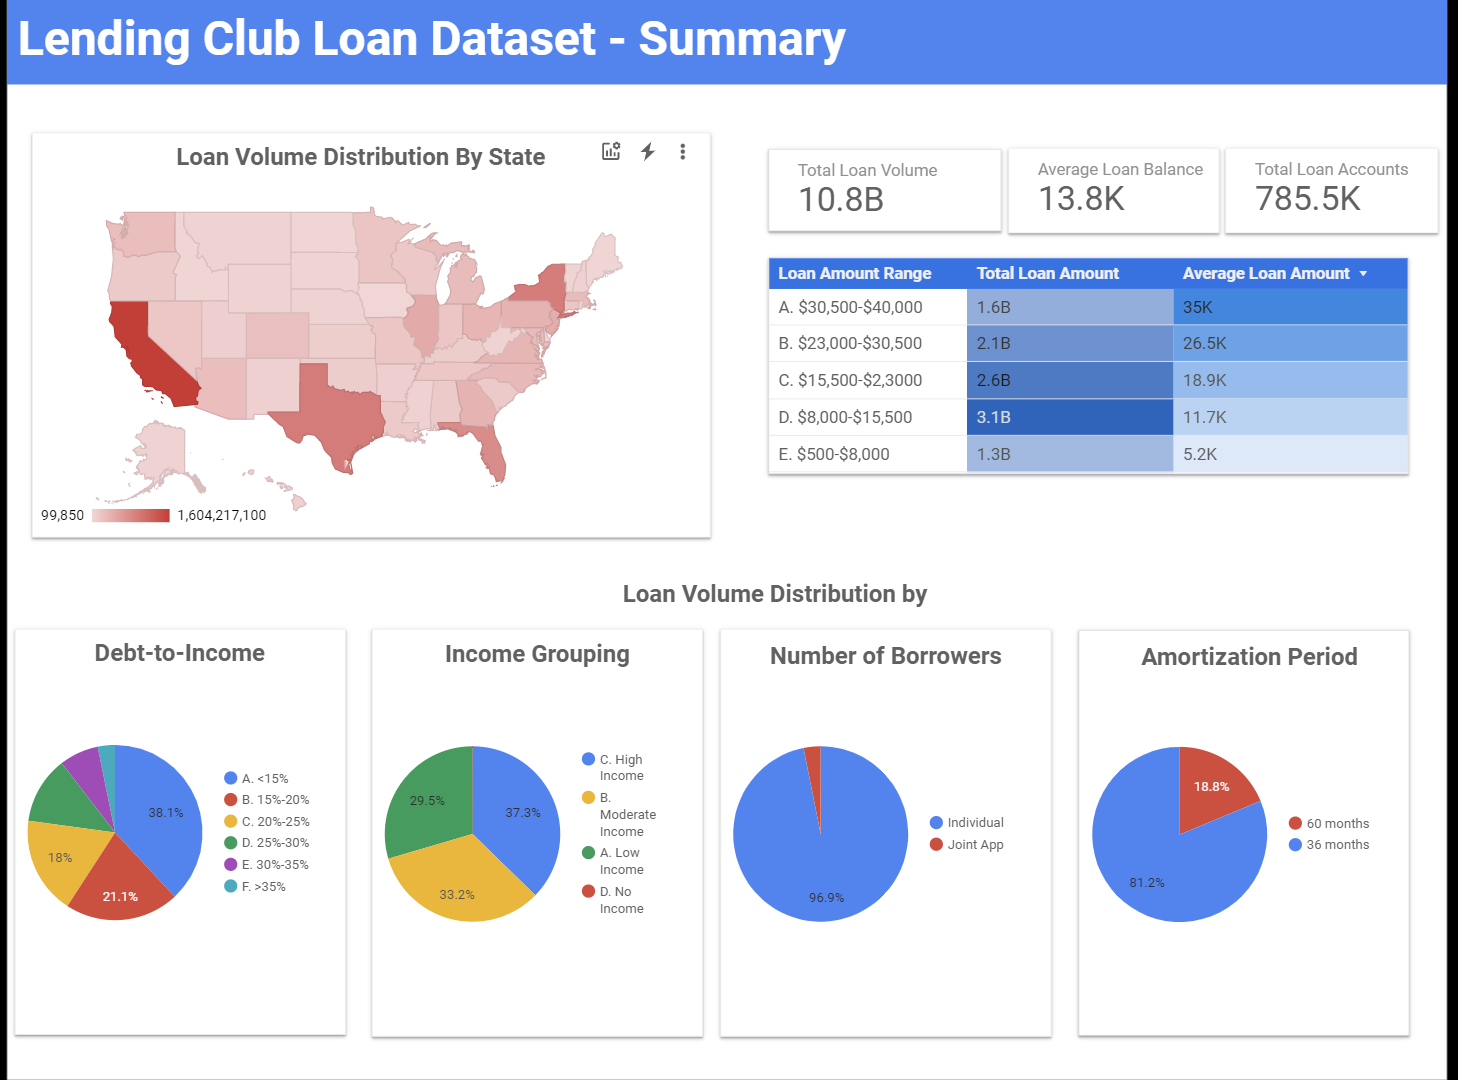

2. 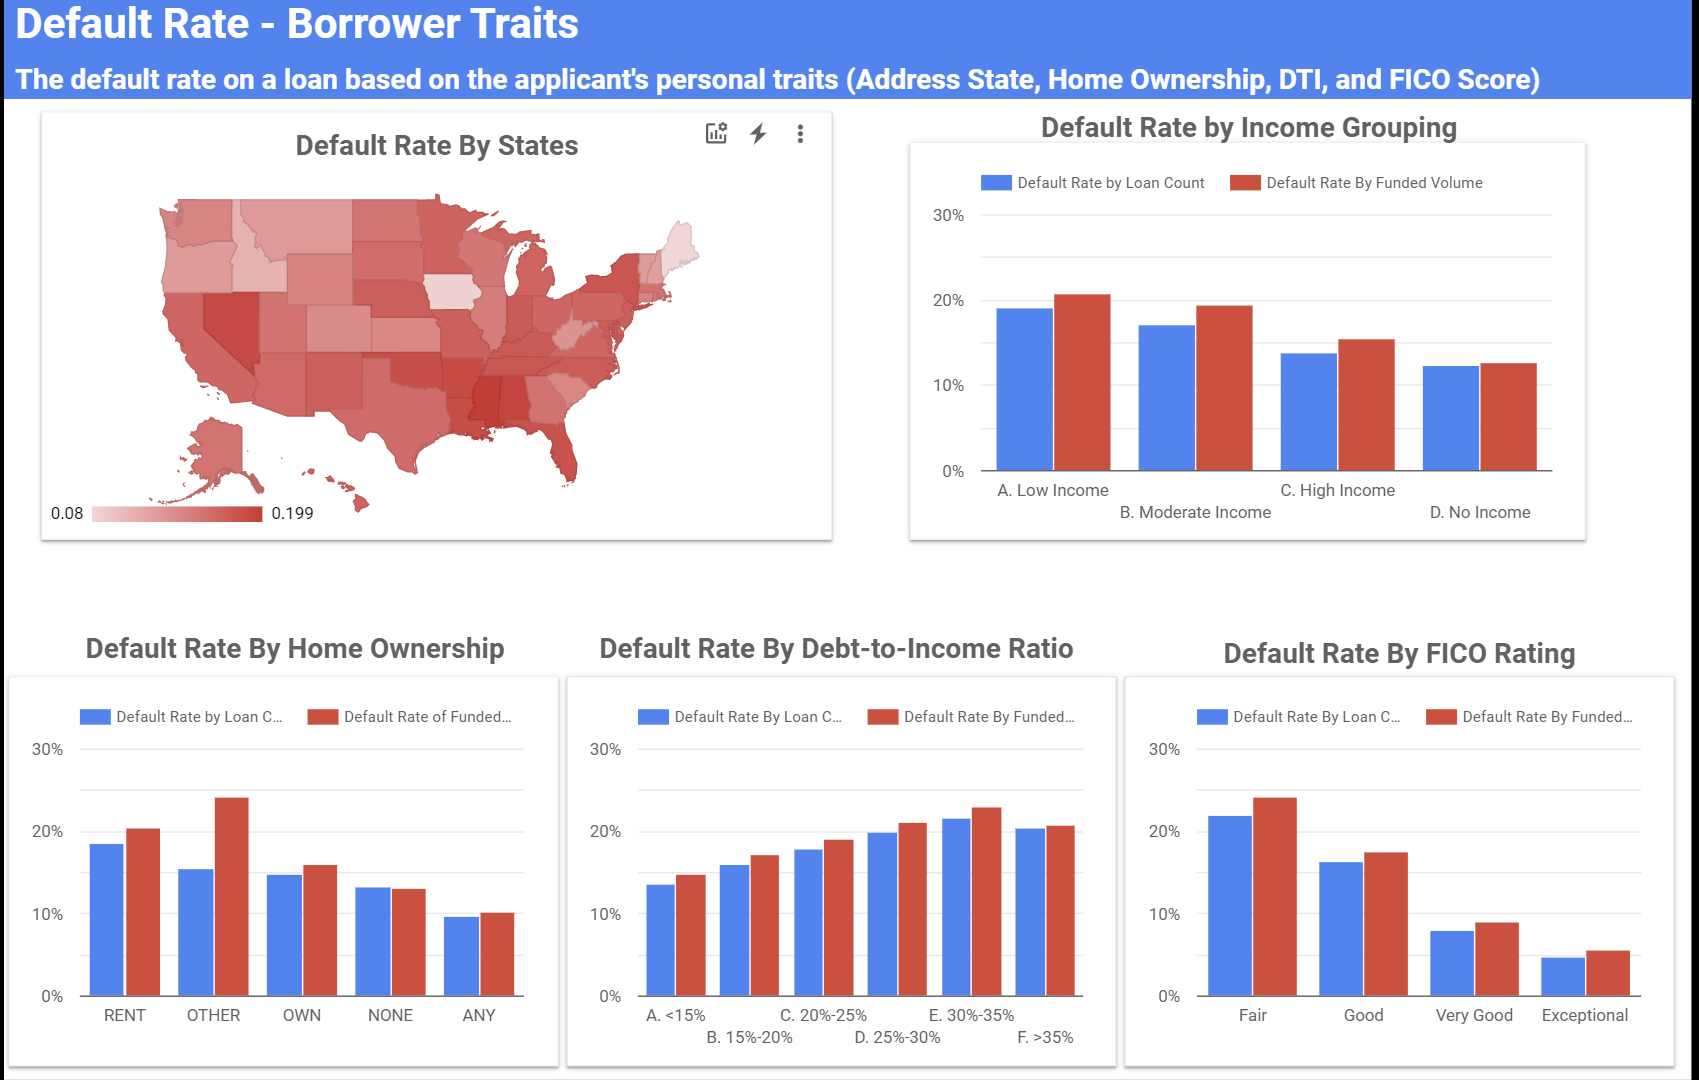

3. 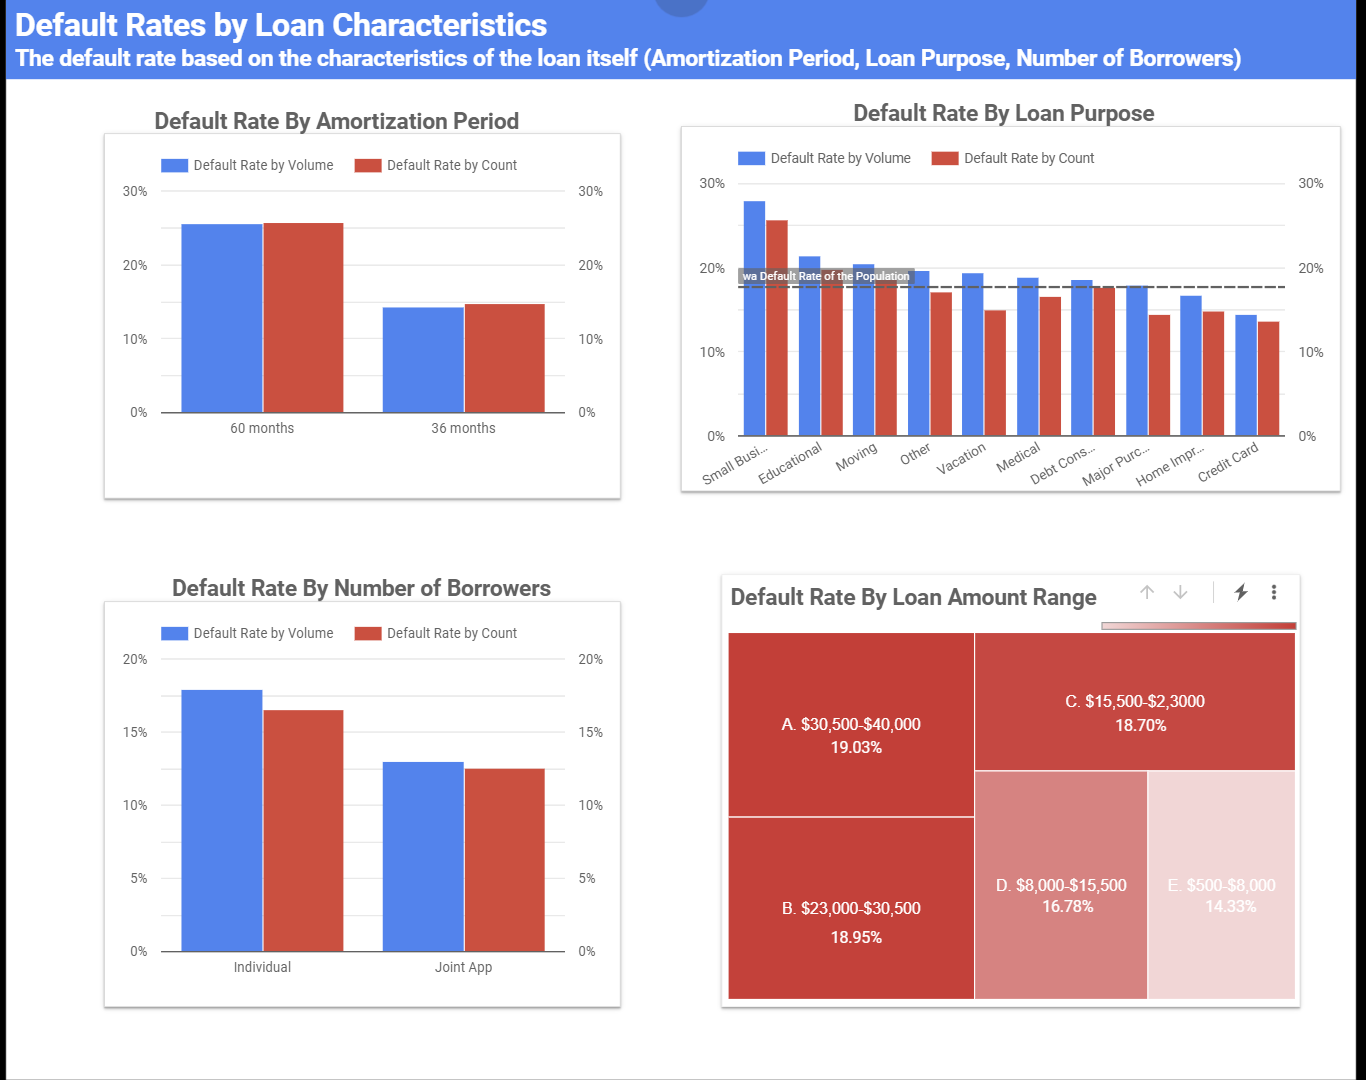